# Управление рисками 2024. Домашнее задание №1.

*Дата выдачи: 06.03.2024*

*Дедлайн: 20.03.2024, 23:59*

## Часть 1. График линейности признака по WoE.

В этой части домашки мы познакомимся с одним из основных инструментов для анализа переменных в модели логистической регрессии - графиком линейности.

Кратко идею этого графика можно сформулировать так:
 - модель *линейной* регрессии корректно применять, если значение $y$ *линейно* связано со значением $x$. Иначе линрег не подходит для данной задачи и даст неверные результаты.
 - аналогичную проверку хочется сделать и для *логистической* регрессии. Но как проверить линейность, если таргет принимает всего два значения?
 - для этого необходимо преобразовать таргет: разбить признак на бакеты и в каждом бакете посчитать WoE
 - **линейность признака по WoE для логрега – аналог линейной связи признака и таргета для линрега**

Ниже пример признака с неплохой линейностью:

![example.png](attachment:example.png)


Нам нужно обратить внимание на 3 вещи:

**1. Фиолетовые точки с доверительными интервалами.**

Это WoE для каждого отдельного бакета. В идеале нам бы хотелось, чтобы **через эти точки можно было провести прямую линию** с небольшой погрешностью. Это и означает линейную взаимосвязь с таргетом.

**2. Синяя линия**

Попытка провести прямую линию через точки. Строится с помощью логистической регрессии на одной переменной. Затем предсказания переводятся в пространство WoE, отчего и получается прямая линия.

**3. Метрики в заголовке графика**

Метрики для признака:
 - roc auc, IV измеряют разделяющую способность переменной
 - $R^2$ измеряет *линейность взаимосвязи*. Признак считается линейным, если $R^2 \geq 0.95$

Далее напишем woe-line руками, чтобы в деталях разобраться, как он строится.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
from typing import Union, Tuple

### Шаг 0: разбиение на бакеты

In [ ]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

### Шаг 1: расчет WoE по бакетам

Пусть $x_i \in \{ 0, 1\}^n$

$x_i$ - это вектор, состоящий из значений таргета *в одном бакете* $i$.

Для бакета можно посчитать количество единиц $B_i$ (bads, выпавшие в дефолт) и количество нулей $G_i$ (goods).

$$
B_i = \sum_{j \in x_i} \mathbb{I} \{ j = 1\}\quad G_i = \sum_{j \in x_i} \mathbb{I} \{ j = 0\}
$$

Также число бэдов и гудов можно посчитать и **для всей выборки**:

$$
% X = x_1 \cup x_2 \ldots \cup x_n
X = \{x_1,\; x_2\; \ldots\; x_n\}
$$

$$
B = \sum_{j \in X} \mathbb{I} \{ j = 1\}\quad G = \sum_{j \in X} \mathbb{I} \{ j = 0\}
$$

Тогда WoE можно посчитать как

$$
\text{WoE}_i(x) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big )
$$

**Задание**

Убедиться, что

$$
\text{WoE}_i(x) = \text{logit}(b_i) - \text{logit}(b)\quad  (1)
$$

где

$$
b = \frac{B}{B + G}\quad \text{logit}(p) = \ln \Big (  \frac{p}{1 - p} \Big )
$$

В дальнейшем будем считать WoE по формуле $(1)$

In [ ]:
from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    if badrate>=1:
      badrate=0.999
    if badrate<=0:
      badrate=0.001
    if offset<=0:
      offset=0.001
    if offset>=1:
      offset=0.999
    woe = logit(badrate) - logit(offset)
    return woe

Здесь и далее предлагается протестироать получившиеся функции. Нужно проверить, что
 - функция не ложится с ошибкой
 - возвращает то, что ожидается

In [ ]:
woe_transform(1,1)

0.0

Ниже представлен шаблон функции, которая будет считать доверительный интервал к нашим вычислениям. Можно воспользоваться любым способом, который вам больше нравится. Для идей можно посмотреть различные способы подсчета доверительного интервала [здесь](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval).

**P. S.**
Для того, чтобы построить доверительный интервал к $WoE$, можно сначала построить его для величины  $b_i = \frac{B_i}{B_i+G_i}$, а потом применить ```woe_transform```. В свою очередь величина $b_i$ является параметром распределения Бернулли, который мы можем оценить классическими методами (см. ссылку выше)

In [ ]:
from scipy.stats import norm
def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""
    badi = np.sum(target==1)
    goodi = np.sum(target==0)
    badrate = badi/(badi+goodi)

    SE = (badrate*(1-badrate))/(badi+goodi)
    Z = norm.ppf(1 - (1-0.95)/2)
    #рассчитали бэдрейт
    badrate_lower = badrate-Z*SE
    badrate_upper = badrate+Z*SE

    # переходим от бэдрейта к woe
    woe, woe_lower, woe_upper = woe_transform(badrate,offset), woe_transform(badrate_lower,offset), woe_transform(badrate_upper,offset)

    return woe, woe_lower, woe_upper

### Шаг 2: расчет линейной интерполяции

In [ ]:
from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""
    # строим логистическую регрессию на одном признаке
    X,y = values, target
    lg = LogisticRegression()
    model = lg.fit(values.reshape(-1,1),target)
    # и считаем ее предсказания в точках – mean_feature
    proba = model.predict_proba(mean_feature.reshape(-1,1))[:,1]
    line=[]
    for i in proba:
      line.append(woe_transform(i, offset))
    return np.array(line)

### Шаг3: собираем результаты по бакетам в один словарь

In [ ]:
def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""
    # вычисляем для кажого бакета и возвращаем массивы данных в порядке для каждого бакета,
    # например в для нулевого индекса будет всё расчитано для первого бакета)
    # Долго не мог понят, как это грамотно сделать, поэтому включил кастыли
    offset = np.sum(target==1)/(np.sum(target==1)+np.sum(target==0))
    data_f = pd.DataFrame({'values': values,'buckets':buckets,'target':target})
    mean_feature = []
    line = []
    woe = []
    woe_lower=[]
    woe_upper=[]
    data_f.head()
    for i in np.unique(buckets):
      valuei = data_f.loc[(data_f['buckets']==i)]['values'].values
      bucketsi = data_f.loc[(data_f['buckets']==i)]['buckets'].values
      targeti =  data_f.loc[(data_f['buckets']==i)]['target'].values
      mean_featurei = np.mean(valuei)
      woei, woe_loweri, woe_upperi = woe_ci(targeti, bucketsi,offset)
      mean_feature.append(mean_featurei)
      woe.append(woei)
      woe_lower.append(woe_loweri)
      woe_upper.append(woe_upperi)
    buckets_info = {
        "mean_feature" : mean_feature,
        "line"         : calc_line(values,target,np.array(mean_feature),offset),
        "woe"          : woe,
        "woe_lower"    : woe_lower,
        "woe_upper"    : woe_upper
    }

    return buckets_info

In [ ]:
# протестируйте calc_buckets_info

### Шаг 4: считаем метрики признака

Рассчитаем также несколько метрик, чтобы судить о качестве признака не только по картинкам.

Приведем формулу для IV:

$$
\text{IV}(x) = \sum_{i = 1}^{n}\Big ( \frac{B_i}{B} - \frac{G_i}{G} \Big ) \times \text{WoE}_i
$$

**Вопрос:** зачем считать ранжирующую силу признака двумя способами? Какую дополнительную информацию может дать IV относительно roc auc?

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    lg = LogisticRegression()
    model = lg.fit(values.reshape(-1,1),target)
    auc = roc_auc_score(target,model.predict_proba(values.reshape(-1,1))[:, 1])
    data_f = pd.DataFrame({'values': values,'buckets':buckets,'target':target})
    # формула выше
    bad = sum(target==1)
    good = sum(target==0)
    backets_u = data_f['buckets'].unique()
    IV = 0
    for i in backets_u:
      badi = sum(data_f.loc[(data_f['buckets']==i)]['target'].values ==1)
      goodi = sum(data_f.loc[(data_f['buckets']==i)]['target'].values==0)
      IV += ((badi/bad)-(goodi/good))*woe_transform(badi/(badi+goodi),bad/(bad+good))

    # Взвешенный R^2
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете
    X=[]
    Y=[]
    weight=[]
    for i in backets_u:
      X.append(data_f.loc[(data_f['buckets']==i)]['values'].mean())
      badi = sum(data_f.loc[(data_f['buckets']==i)]['target'].values ==1)
      goodi = sum(data_f.loc[(data_f['buckets']==i)]['target'].values==0)
      Y.append(woe_transform(badi/(badi+goodi),bad/(bad+good)))
      weight.append(sum(buckets==i))

    R_sqr = r2_score(calc_line(values,target,np.array(X),bad/(bad+good)),Y, sample_weight=weight)

    plot_title = (
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

In [ ]:
# протестируйте calc_plot_title

### Шаг 5: собираем все в одну функцию и строим график

In [ ]:
# в этот код можно не въезжать :)
import plotly.graph_objects as go

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

In [ ]:
def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

Чтобы протестировать реализацию, сгенерируем синтетические данные:

In [ ]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

In [ ]:
sns.histplot(df, x = 'feature', hue = 'target')

<Axes: xlabel='feature', ylabel='Count'>

In [ ]:
# запустите после того, как реализуете все функции
woe_line(values=x, target=y, n_buckets=5)

### Эксперименты

#### №1

Как будут меняться график, метрики разделяющей способности и $R^2$ при изменении дисперсии шума (параметр `noise_std`)?

In [ ]:
sample_size = int(1e4)
noise_std = 2.
df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

woe_line(values=x, target=y, n_buckets=30)

Если поменять значения noise_std, то можно заметить, как уменьшается IV при этом AUC не сильно меняется, также график становится не линейным при увеличении noise_std

#### №2

Запустите функцию с `values=x ** 2`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

In [ ]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x
woe_line(values=(x), target=y, n_buckets=20)

In [ ]:
woe_line(values=(x**2), target=y, n_buckets=20)

Квадрат по графику определить очень легко, т.к в таком случае большое количество средних значений по бакетам будут в начале графика, также все средние значения по бакетам будут не меньше 0, из-за того, что квадрат убирает знак. Чтобы хоть как-то исправить ситуацию мы можем взять функцию корня от Х

In [ ]:

woe_line(values=(x**2)**0.5, target=y, n_buckets=20)

#### №3

Запустите функцию с `values=np.exp(x)`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

In [ ]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x
woe_line(values=(np.exp(x)), target=y, n_buckets=20)

Если кучосно заданный график образует подобие функции логарифма, и также наблюдается скопление значений бакетов в начале графика, то это скорее всего exp(x), чобы исправить ситуацию можно преобразовать х с помощью натурального логарифма

In [ ]:
woe_line(values=np.log((np.exp(x))), target=y, n_buckets=20)

## Часть 2. Строим ЛогРег.

В этом пунтке попробуем применить все наши навыки

Скачайте датасет по [ссылке](https://data.tinkoff.ru/s/Nca7PoTNYokXgNF). Пароль вы найдете в телеграм-канале курса, в посте с анонсом домашки.

In [ ]:
df = pd.read_csv('risks-24-hw1.csv', index_col=0)
df

feature_1  feature_2     feature_3  feature_4  feature_5  feature_6  \
0      -1.444709   3.554779      1.308371  -0.689329   0.366748   2.646755   
1       1.132531  -0.207661     -2.142882   0.000527   2.369319   8.712916   
2       1.268781  -0.243999  10000.000000   0.000683   0.100580   2.137392   
3      -1.278475  -2.579890      5.050763  -0.371907   0.523984   2.612065   
4       3.507807   0.152661     -8.905005   0.939313   1.092974   4.224315   
...          ...        ...           ...        ...        ...        ...   
99995  -3.061422  -0.163832      4.812768  -0.417794   0.182394  -0.582374   
99996   0.222451  -0.273191      0.380895   0.002889   3.724334   1.007479   
99997   1.078498   0.339526     -5.184847   0.234131   0.544720  -3.320917   
99998  -1.431421  -0.605388      2.466023  -0.009963   0.308079   6.889658   
99999   0.435883  -0.336180     -4.599904   0.051063   0.099353   1.267455   

       feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0              1   8.825418   2.646755   11.565953 -513.014565   -1.072893   
1              1   3.453220   8.712916    4.935665  -39.351891    3.409855   
2              1 -10.116061   2.137392    6.234414   -4.993050    3.121126   
3              1   6.780814   2.612065    2.682539 -509.273095   -1.242741   
4              1 -10.638134   4.224315    6.881602   -2.034797    2.814972   
...          ...        ...        ...         ...         ...         ...   
99995          0  -9.959913  -0.582374    5.294558 -524.265291   -1.648415   
99996          1  -1.645952   1.007479    5.571499  -13.499956    3.386865   
99997          1  -5.565932  -3.320917   -0.433263    3.928387    3.290285   
99998          0  -4.517188   6.889658   10.812813 -507.593408   -1.398568   
99999          1  -4.782919   1.267455    3.534312  -11.032778    3.293867   

        feature_13  feature_14 feature_15  d4p12  
0         7.936545    0.047069          B      1  
1        17.015210    0.029288          A      0  
2         4.878602    0.237255          A      0  
3        20.293025    0.907788          B      0  
4         7.352399    0.276854          A      0  
...            ...         ...        ...    ...  
99995     5.410059    0.855190          B      0  
99996    92.903615    0.006668          A      1  
99997     1.233853    0.160933          A      1  
99998  1904.246147    0.077164          B      1  
99999   142.502312    0.002221          A      1  

[100000 rows x 16 columns]

Как вы выдите, ```feature_1, ..., feature_14``` - числа
```feature_15``` - категориальная фича

### Задание 0. EDA.

Как бы вы начали знакомиться с данными до построения модели? Постройте 3-5 графиков / таблиц, чтобы передать основную информацию о датасете.

In [ ]:
import matplotlib.pyplot as plt
df['feature_1'].plot()
plt.show()

df['feature_2'].plot()
df['feature_2'].mean()

-0.19882694630065254

По анализу графика значений второй фичи заметно, что она имеет какие-то выбросы в данных, так если среднее значение второй фичи находится около 0, то выбросы имеют значения в нескольно тысяч

In [ ]:
dr = df.loc[(abs(df['feature_3'])>1000)]
pd.crosstab(dr['d4p12'], dr['feature_3'])

feature_3  -10000.0   10000.0
d4p12                        
0              1317       606
1              1462      2110

In [ ]:
pd.crosstab(dr['feature_15'], dr['feature_3'])

feature_3   -10000.0   10000.0
feature_15                    
A                  0      2716
B               2779         0

По графику значени второй переменной заметно, что есть какиe-то выбросы, если мы посмотрим на строки где есть эти выбросы, то легко заметим, что значение 15 фичи будет всегда А, если f_3=10000, а если f_3=-10000, то значение В, тогда надо посмотреть на зависимость этих признаков без выбросов

In [ ]:
dl = df.loc[((df['feature_3'])<0)]
dl = dl.loc[((dl['feature_3'])>-1000)]
dl['feature_15'].value_counts()

feature_15
A    36796
B    10406
Name: count, dtype: int64

In [ ]:
dr = df.loc[((df['feature_3'])>0)]
dr = dr.loc[((dr['feature_3'])<1000)]
dr['feature_15'].value_counts()

feature_15
B    36921
A    10382
Name: count, dtype: int64

Как видим, если третья фича положительная, то значений B будет в 4 раза больше значений A, а если отрицательные, то наоборот(какая-то зависимость)

In [ ]:
dr = df.loc[((df['feature_3'])>-1000)]
dr = dr.loc[((dr['feature_3'])<1000)]
dr['feature_15'].value_counts()

feature_15
B    47327
A    47178
Name: count, dtype: int64

### Задание 1. Бейзлайн.

Попробуйте построить ЛогРег только на числовых данных. Для этого разбейте датасет на трейн и тест (80/20). Перед обучением логрега стандартизуйте переменные. Это может быть полезно для численной устойчивости алгоритмов оптимизации.

Для этой модели и всех дальнейших:

1. Получилась ли модель линейной? Постройте график линейности на трейне и на тесте и сделайте вывод.
2. Расчитайте AUC и IV на трейне и на тесте. Что можно сказать о переобучении?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
data = df.copy()
data.drop('feature_15',axis=1, inplace = True)
X = ['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7',
     'feature_8','feature_9','feature_10','feature_11','feature_12','feature_13','feature_14']
y =['d4p12']
X_train,X_test,y_train,y_test = train_test_split(data[X],data[y], test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
lg = LogisticRegression()
values,target = X_train,y_train
model = lg.fit(values,target.values.ravel())
woe_line(model.predict_proba(values)[:, 1],y_train.values.ravel(),15)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



array([[0.65793558, 0.34206442],
       [0.62022913, 0.37977087],
       [0.46051391, 0.53948609],
       ...,
       [0.52645051, 0.47354949],
       [0.45050909, 0.54949091],
       [0.4484969 , 0.5515031 ]])

In [ ]:
woe_line(model.predict_proba(X_test)[:, 1],y_test.values.ravel(),15)

Модель получилась достаточно линейной, имеент хорошие значения IV и R_sqr, также данные не сильно отличают на тесте и на трейне, так же AUC не сильно отличается на тест и на трейне, значит модель не переобучилась

In [ ]:
auc_train = roc_auc_score(target, model.predict_proba(values)[:, 1])
auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(auc_train,auc_test)

0.7076225282553555 0.7062311275135054


### Задание 2. Добавляем категориальную переменную.

Повторите задание 1, включив в модель категориальную переменную (например, с помощью one-hot encoding).

Улучшилось ли качество?

In [ ]:
df['feature_15'] = df['feature_15'].replace(['A','B'],[1,0])
df.shape

(100000, 16)

In [ ]:
data = df.copy()
X = ['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7',
     'feature_8','feature_9','feature_10','feature_11','feature_12','feature_13','feature_14','feature_15']
y =['d4p12']
X_train,X_test,y_train,y_test = train_test_split(data[X],data[y], test_size=0.2, random_state=42)

In [ ]:
X_train.values

array([[-3.27600930e+00,  1.43596257e-01,  4.89747681e+00, ...,
         5.85002363e+03,  2.43341491e-06,  0.00000000e+00],
       [-3.42103314e+00,  1.83404459e-01,  4.21706244e+00, ...,
         2.04859870e+02,  9.98572448e-01,  0.00000000e+00],
       [ 2.10723629e+00,  6.09639619e-01, -1.99691002e+00, ...,
         3.37889925e+01,  9.99032582e-01,  1.00000000e+00],
       ...,
       [ 2.35632547e-01, -1.99828012e+00, -5.97039822e+00, ...,
         8.51050511e-03,  5.05005893e-01,  1.00000000e+00],
       [ 5.75242353e-01,  7.83175634e-01, -9.29454788e+00, ...,
         2.43361424e-01,  4.98270184e-03,  1.00000000e+00],
       [ 8.31570938e-01,  6.54175516e-01, -9.45585594e+00, ...,
         2.48518428e-01,  3.14910805e-01,  1.00000000e+00]])

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
y_train.values.ravel()

array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
lg = LogisticRegression()
values,target = X_train,y_train
model = lg.fit(values,target.values.ravel())
woe_line(model.predict_proba(values)[:, 1],y_train.values.ravel(),15)

In [ ]:
woe_line(model.predict_proba(X_test)[:, 1],y_test.values.ravel(),15)

Как видим AUC вырос, но при этом очень сильно выросло IV, и наша модель перестала быть линейной по WOE(, очень грустно сейчас бдует исправлять, модель также не переобучилась


### Задание 3. Линеаризация переменных.

На самом деле, категориальные переменные можно учитывать в моделях совсем по-другому. С их помощью можно выделить в модели сегменты. Каждому сегменту соответствует своя модель (в нашем случае логрег).

Примером такой сегментации может стать сегментация по наличию кредитной истории. В этом случае на разных сегментах будут не просто отдельные модели, но и даже разный изначальный набор признаков. Другое свидетельство удачной сегментации – разный характер зависимости признаков и целевой переменной. Это можно увидеть на графике линейности признака по WoE. Этим мы и займемся далее.

Используйте переменную 15 для сегментации модели. На каждом из двух сегментов линеаризуйте переменные. Для этого приложите:
 - график линейности переменной до преобразования
 - график после подобранного преобразования

Помимо этого:
 - попробуйте линеаризовать какие-нибудь 2 переменные *на всей выборке*. Получилось ли у вас что-то? Постройте график.
 - по графику линейности определите шумовые (либо слабоинформативные) переменные. В конце задания приложите их список.

In [ ]:
df

feature_1  feature_2     feature_3  feature_4  feature_5  feature_6  \
0      -1.444709   3.554779      1.308371  -0.689329   0.366748   2.646755   
1       1.132531  -0.207661     -2.142882   0.000527   2.369319   8.712916   
2       1.268781  -0.243999  10000.000000   0.000683   0.100580   2.137392   
3      -1.278475  -2.579890      5.050763  -0.371907   0.523984   2.612065   
4       3.507807   0.152661     -8.905005   0.939313   1.092974   4.224315   
...          ...        ...           ...        ...        ...        ...   
99995  -3.061422  -0.163832      4.812768  -0.417794   0.182394  -0.582374   
99996   0.222451  -0.273191      0.380895   0.002889   3.724334   1.007479   
99997   1.078498   0.339526     -5.184847   0.234131   0.544720  -3.320917   
99998  -1.431421  -0.605388      2.466023  -0.009963   0.308079   6.889658   
99999   0.435883  -0.336180     -4.599904   0.051063   0.099353   1.267455   

       feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0              1   8.825418   2.646755   11.565953 -513.014565   -1.072893   
1              1   3.453220   8.712916    4.935665  -39.351891    3.409855   
2              1 -10.116061   2.137392    6.234414   -4.993050    3.121126   
3              1   6.780814   2.612065    2.682539 -509.273095   -1.242741   
4              1 -10.638134   4.224315    6.881602   -2.034797    2.814972   
...          ...        ...        ...         ...         ...         ...   
99995          0  -9.959913  -0.582374    5.294558 -524.265291   -1.648415   
99996          1  -1.645952   1.007479    5.571499  -13.499956    3.386865   
99997          1  -5.565932  -3.320917   -0.433263    3.928387    3.290285   
99998          0  -4.517188   6.889658   10.812813 -507.593408   -1.398568   
99999          1  -4.782919   1.267455    3.534312  -11.032778    3.293867   

        feature_13  feature_14  feature_15  d4p12  
0         7.936545    0.047069           0      1  
1        17.015210    0.029288           1      0  
2         4.878602    0.237255           1      0  
3        20.293025    0.907788           0      0  
4         7.352399    0.276854           1      0  
...            ...         ...         ...    ...  
99995     5.410059    0.855190           0      0  
99996    92.903615    0.006668           1      1  
99997     1.233853    0.160933           1      1  
99998  1904.246147    0.077164           0      1  
99999   142.502312    0.002221           1      1  

[100000 rows x 16 columns]

###Feature_15=A


In [ ]:
data_1 = df.loc[(df['feature_15']==1)]
X = ['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7',
     'feature_8','feature_9','feature_10','feature_11','feature_12','feature_13','feature_14']
y = ['d4p12']
X_train,X_test,y_train,y_test = train_test_split(data_1[X],data_1[y], test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
lg = LogisticRegression()
values,target = X_train,y_train
model = lg.fit(values,target.values.ravel())
woe_line(model.predict_proba(values)[:, 1],y_train.values.ravel(),15)

In [ ]:
woe_line(model.predict_proba(X_test)[:, 1],y_test.values.ravel(),15)

#### ПЕРВЫЙ ПРИЗНАК

In [ ]:
#проверяем линейность первого признака
woe_line(X_train[:, 0],y_train.values.ravel(),15)

In [ ]:
woe_line((np.log(X_train[:, 0]+0.8)),y_train.values.ravel(),15)

In [ ]:
data_1['feature_1']=np.log(np.array(data_1['feature_1'])+0.8)


<ipython-input-3339-482e2170202b>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Линеразовал 1 признак сдвигом на 0.8 и взятие логарифма)

#### Второй признак


In [ ]:
#проверяем линейность второго признака
woe_line(X_train[:, 1],y_train.values.ravel(),15)

In [ ]:
X_train1=X_train
woe_line(np.log((X_train1[:, 1]).clip(0,0.02)+1),y_train.values.ravel(),15)

Явно нелинейный признак, исключим его из анализа)

In [ ]:
 data_1.drop('feature_2',axis=1, inplace = True)

<ipython-input-3342-63af6cd15197>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Третий признак

In [ ]:
woe_line(X_train[:, 2],y_train.values.ravel(),15)

In [ ]:
#проверяем линейность третьего признака()
woe_line((X_train[:, 2].clip(-1,-0.235)),y_train.values.ravel(),15)

Видим похожую картину, что было и со второй фичой, тоже кик)

In [ ]:
data_1['feature_3']= np.array(data_1['feature_3']).clip(-1,-0.235)

<ipython-input-3345-22f2397f37bf>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Четвёртый признак

In [ ]:
#проверяем линейность четвёртого признака
woe_line(X_train[:, 3],y_train.values.ravel(),15)

In [ ]:
woe_line((X_train[:, 3]).clip(-1.5,1),y_train.values.ravel(),15)

In [ ]:
data_1.drop('feature_4',axis=1, inplace = True)
#низкий AUC and нелинейна

<ipython-input-3348-4da541477a43>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Пятый признак

In [ ]:
#проверяем линейность пятого признака
woe_line(X_train[:, 4],y_train.values.ravel(),15)

In [ ]:
data_1.drop('feature_5',axis=1, inplace = True)
#низкий AUC and нелинейна

<ipython-input-3350-3f2266fdc7d3>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 6 признак


In [ ]:
#проверяем линейность шестого признака
woe_line((X_train[:, 5]),y_train.values.ravel(),15)

In [ ]:
data_1.drop('feature_6',axis=1, inplace = True)
#низкий AUC and нелинейна

<ipython-input-3352-b6644df66136>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 7 Признак

In [ ]:
#проверяем линейность седьмого признака
print(np.unique(X_train[:, 6]))
woe_line((X_train[:, 6]),y_train.values.ravel(),15)

[-3.04838919  0.3280421 ]


In [ ]:
data_1.drop('feature_7',axis=1, inplace = True)
#низкий AUC and нелинейна

<ipython-input-3354-2cba7e8b3a8e>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Оставляем)

#### Признак 8

In [ ]:
#проверяем линейность восьмого признака
woe_line((X_train[:, 7]),y_train.values.ravel(),15)

In [ ]:
woe_line(abs(X_train[:, 7])**2*np.sign(X_train[:, 7]),y_train.values.ravel(),15)

In [ ]:
data_1.drop('feature_8',axis=1, inplace = True)
#низкий AUC and нелинейна

<ipython-input-3357-81feab7a73cd>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Признак 9

In [ ]:
#проверяем линейность девятого признака
woe_line((X_train[:, 8]),y_train.values.ravel(),15)

In [ ]:
data_1.drop('feature_9',axis=1, inplace = True)
#низкий AUC and нелинейна

<ipython-input-3359-57089e0be211>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 10 Признак


In [ ]:
#проверяем линейность девятого признака
woe_line((X_train[:, 9]),y_train.values.ravel(),15)

In [ ]:
data_1.drop('feature_10',axis=1, inplace = True)
#низкий AUC and нелинейна

<ipython-input-3361-12884e0aeca1>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 11 признак


In [ ]:
#проверяем линейность одиннадцатого признака
woe_line((X_train[:, 10]),y_train.values.ravel(),15)

In [ ]:
woe_line((abs(X_train[:, 10])**(0.5))*np.sign(X_train[:, 10]),y_train.values.ravel(),15)

Смогли линерализовать фичу, добавим в data_1

In [ ]:
data_1['feature_11']=np.abs(np.array(data_1['feature_11']))**0.5*np.sign((np.array(data_1['feature_11'])))

<ipython-input-3364-c165eae217c0>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 12 признак

In [ ]:
#проверяем линейность двеннадцатого признака
woe_line((X_train[:, 11]),y_train.values.ravel(),15)

In [ ]:
woe_line((X_train[:, 11].clip(-1.2,100)),y_train.values.ravel(),15)

In [ ]:
data_1['feature_12']=np.array(data_1['feature_12']).clip(-1.2,100)

<ipython-input-3367-9c2a479b7a4a>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Признак 13

In [ ]:
#проверяем линейность триннадцатого признака
woe_line((X_train[:, 12]),y_train.values.ravel(),15)

In [ ]:
data_1.drop('feature_13',axis=1, inplace = True)
#низкий AUC и нелинейна

<ipython-input-3369-61d36a7f2aa7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 14 признак

In [ ]:
#проверяем линейность четырнадцатого признака
woe_line((X_train[:, 13]),y_train.values.ravel(),15)

In [ ]:
woe_line((np.log(abs(X_test[:, 13]+0.763)).clip(-5,0)),y_test.values.ravel(),15)

In [ ]:
data_1['feature_14']=np.array((np.log(abs(data_1['feature_14']+0.763)).clip(-5,0)))
#у меня не получилось сделать её линейной(

<ipython-input-3372-8ed2876fd96a>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
from sklearn.metrics import accuracy_score
X = ['feature_1','feature_3','feature_11','feature_12','feature_14']
y = ['d4p12']
X_train,X_test,y_train,y_test = train_test_split(data_1[X],data_1[y], test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
lg = LogisticRegression()
values,target = X_train,y_train
model1 = lg.fit(values,target.values.ravel())
woe_line(model1.predict_proba(values)[:, 1],y_train.values.ravel(),15)
#accuracy_score(y_train,model.predict(values))
#график линелизации на трейне

In [ ]:
woe_line(model1.predict_proba(X_test)[:, 1],y_test.values.ravel(),15)
#график линелизации на тесте

Вывод: увеличили AUC, избавились от переменных, потеряли в линейности(

### future_15=B

In [ ]:
data_2 = df.loc[(df['feature_15']==0)]
X = ['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7',
     'feature_8','feature_9','feature_10','feature_11','feature_12','feature_13','feature_14','feature_15']
y = ['d4p12']
X_train,X_test,y_train,y_test = train_test_split(data_2[X],data_2[y], test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
lg = LogisticRegression()
values,target = X_train,y_train
model = lg.fit(values,target.values.ravel())
woe_line(model.predict_proba(values)[:, 1],y_train.values.ravel(),15)

In [ ]:
woe_line(model.predict_proba(X_test)[:, 1],y_test.values.ravel(),15)

Видим лютую нелинейность, бежим исправлять

#### ПЕРВЫЙ ПРИЗНАК

In [ ]:
#проверяем линейность первого признака
woe_line(X_train[:, 0],y_train.values.ravel(),15)

In [ ]:
woe_line(((X_train[:, 0]).clip(-0.5,0.8)**2)*np.sign(X_train[:, 0].clip(-0.5,0.8)),y_train.values.ravel(),15)

In [ ]:
data_2['feature_1']=((np.array(data_2['feature_1'])).clip(-0.5,0.8)**2)*np.sign(np.array(data_2['feature_1']).clip(-0.5,0.8))


<ipython-input-3379-ce1235eb5755>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Линеразовал 1 признак сдвигом на 0.8 и взятие логарифма)

#### Второй признак


In [ ]:
#проверяем линейность второго признака
woe_line(X_train[:, 1],y_train.values.ravel(),15)

In [ ]:
woe_line((np.log(abs((X_train[:, 1]).clip(-0.1,0.1)))).clip(10,65),y_train.values.ravel(),15)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.



Явно нелинейный признак, исключим его из анализа)

In [ ]:
data_2.drop('feature_2',axis=1, inplace = True)

<ipython-input-3382-2ab2425771f2>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Третий признак

In [ ]:
woe_line(X_train[:, 2],y_train.values.ravel(),15)

In [ ]:
#проверяем линейность третьего признака()
woe_line((X_train[:, 2].clip(0.24,1)),y_train.values.ravel(),15)

Видим похожую картину, что было и со второй фичой, тоже кик)

In [ ]:
data_2['feature_3']= np.array(data_2['feature_3']).clip(0.24,1)

<ipython-input-3385-ad3f07760beb>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Четвёртый признак

In [ ]:
#проверяем линейность четвёртого признака
woe_line(X_train[:, 3],y_train.values.ravel(),15)

In [ ]:
woe_line((X_train[:, 3]).clip(-1.5,2),y_train.values.ravel(),15)

In [ ]:
data_2.drop('feature_4',axis=1, inplace = True)
#низкий AUC and нелинейна

<ipython-input-3388-a46c7b8dd3bc>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Пятый признак

In [ ]:
#проверяем линейность пятого признака
woe_line(X_train[:, 4],y_train.values.ravel(),15)

In [ ]:
data_2.drop('feature_5',axis=1, inplace = True)
#низкий AUC and нелинейна

<ipython-input-3390-0ab09c6aeabd>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 6 признак


In [ ]:
#проверяем линейность шестого признака
woe_line((X_train[:, 5]),y_train.values.ravel(),15)

In [ ]:
data_2.drop('feature_6',axis=1, inplace = True)
#низкий AUC and нелинейна

<ipython-input-3392-52ae2eed78a9>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 7 Признак

In [ ]:
#проверяем линейность седьмого признака

woe_line((X_train[:, 6]),y_train.values.ravel(),15)

In [ ]:
data_2.drop('feature_7',axis=1, inplace = True)
#низкий AUC and нелинейна

<ipython-input-3394-073bab2ecc7f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Признак 8

In [ ]:
#проверяем линейность восьмого признака
woe_line((X_train[:, 7]),y_train.values.ravel(),15)

In [ ]:
woe_line(abs(X_train[:, 7])**2*np.sign(X_train[:, 7]),y_train.values.ravel(),15)

In [ ]:
data_2.drop('feature_8',axis=1, inplace = True)
#низкий AUC and нелинейна

<ipython-input-3397-5da102b65e34>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Признак 9

In [ ]:
#проверяем линейность девятого признака
woe_line((X_train[:, 8]),y_train.values.ravel(),15)

In [ ]:
data_2.drop('feature_9',axis=1, inplace = True)
#низкий AUC and нелинейна

<ipython-input-3399-9ac4868883ff>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 10 Признак


In [ ]:
#проверяем линейность девятого признака
woe_line((X_train[:, 9]),y_train.values.ravel(),15)

In [ ]:
data_2.drop('feature_10',axis=1, inplace = True)
#низкий AUC and нелинейна

<ipython-input-3401-65c7613eb62f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 11 признак


In [ ]:
#проверяем линейность одиннадцатого признака
woe_line((X_train[:, 10]),y_train.values.ravel(),15)

In [ ]:
woe_line(((abs(X_train[:, 10])**(0.5))*np.sign(X_train[:, 10])).clip(-2,1.1),y_train.values.ravel(),15)

Смогли линерализовать фичу, добавим в data_1

In [ ]:
data_2['feature_11']=(np.abs(np.array(data_2['feature_11']))**0.5*np.sign((np.array(data_2['feature_11'])))).clip(-2,1.1)

<ipython-input-3404-0352e2c15428>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 12 признак

In [ ]:
#проверяем линейность двеннадцатого признака
woe_line((X_train[:, 11]),y_train.values.ravel(),15)

In [ ]:
woe_line((X_train[:, 11].clip(-100,1.3)),y_train.values.ravel(),15)

In [ ]:
data_2['feature_12']=np.array(data_2['feature_12']).clip(-100,1.3)

<ipython-input-3407-7e62e84fc197>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Признак 13

In [ ]:
#проверяем линейность триннадцатого признака
woe_line((X_train[:, 12]),y_train.values.ravel(),15)

In [ ]:
data_2.drop('feature_13',axis=1, inplace = True)
#низкий AUC и нелинейна

<ipython-input-3409-0ae87ac48509>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 14 признак

In [ ]:
woe_line(((X_train[:, 13])),y_train.values.ravel(),15)

In [ ]:
#проверяем линейность четырнадцатого признака
woe_line((np.log((X_train[:, 13])+0.77)).clip(-5.4,0),y_train.values.ravel(),15)

In [ ]:
data_2['feature_14']=np.array((np.log(abs(data_2['feature_14']+0.77)).clip(-5,0)))

<ipython-input-3412-4199e9f1c1d5>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
from sklearn.metrics import accuracy_score
X = ['feature_1','feature_3','feature_11','feature_12','feature_14']
y = ['d4p12']
X_train,X_test,y_train,y_test = train_test_split(data_2[X],data_2[y], test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
lg = LogisticRegression()
values,target = X_train,y_train
model2 = lg.fit(values,target.values.ravel())
woe_line(model2.predict_proba(values)[:, 1],y_train.values.ravel(),15)
# accuracy_score(y_train,model2.predict(values))
#график линелизации на трейне

Смею предположить, что нелинейсность в начале связана с нелинейностью 14

In [ ]:
woe_line(model2.predict_proba(X_test)[:, 1],y_test.values.ravel(),15)

Увеличилась R_sqr модель стала более линейной, но также меньшился AUC(

### Линенеаризуем первую и 11 переменные на всей выборке

1 переменная

In [ ]:
data = df.copy()
X = ['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7',
     'feature_8','feature_9','feature_10','feature_11','feature_12','feature_13','feature_14','feature_15']
y =['d4p12']
X_train,X_test,y_train,y_test = train_test_split(data[X],data[y], test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
woe_line((X_train[:, 0]),y_train.values.ravel(),15)

In [ ]:
woe_line(np.log(abs(X_train[:, 0].clip(-1,1))).clip(-2.5,0),y_train.values.ravel(),15)

11 признак

In [ ]:
woe_line((X_train[:, 10]),y_train.values.ravel(),15)

In [ ]:
woe_line((abs(np.log((abs(X_train[:, 10]))))*np.sign(X_train[:, 10])),y_train.values.ravel(),15)

In [ ]:
# не линерализуется

# Задание 4. Финальная модель.

Обучите модели на признаках, которые вы отобрали и линеаризовали в задании 3. Пусть $logit_A$ – модель, обученная на сегменте $feature_{15} = A$. $logit_B$ – модель на втором сегменте. Тогда модель на всей выборке будем считать по формуле

$$
logit(x) = \mathbb I \{ feature_{15} = A \} \times logit_A(x) + \mathbb I \{ feature_{15} = B \} \times logit_B(x)
$$


Посчитайте для этой модели AUC и IV, оцените линейность на трейне и тесте. Сравните результаты с бейзлайном из задания 1.

Подсказка: если вы все сделали правильно, можно ожидать ROC AUC около 0.9 на тестовой выборке.

In [ ]:
data = df.copy()
X = ['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7',
     'feature_8','feature_9','feature_10','feature_11','feature_12','feature_13','feature_14','feature_15']
y =['d4p12']
X_train,X_test,y_train,y_test = train_test_split(data[X],data[y], test_size=0.2, random_state=42)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
import math
def lin_featureA(x):
  x[0]=(math.log(x[0]+0.8))
  x[1]=x[1].clip(-1,-0.235)
  x[2]=(abs(x[2])**(0.5))*np.sign(x[2])
  x[3]=x[3].clip(-1.2,100)

In [ ]:
def lin_featureB(x):
  x[0]=(x[0].clip(-0.5,0.8)**2)*np.sign(x[0]).clip(-0.5,0.8)
  x[1]= x[1].clip(0.24,1)
  x[2]=(abs(x[2])**(0.5))
  x[3]=x[3].clip(-100,1.3)

In [ ]:
# def predict_AB(x):
#   if x[14]>0:
#     X_features = x[[0,2,10,11,13]]
#     lin_featureA(X_features)
#     return model1.predict_proba(X_features.reshape(1, -1))[:,1]
#   else:
#      X_features = x[[0,2,10,11]]
#      lin_featureB(X_features)
#      return model2.predict_proba(X_features.reshape(1, -1))[:,1]
# y_proba = []
# for x in X_test:
#   y_proba.append()
# woe_line(np.array(y_proba).ravel(),y_test.values.ravel(),15)
# К сожалению у меня не получилось сделать объединение двух функций


# Часть 3. Бонус.

На лекции мы накопили ряд упражнений, которые стоит решить для понимания происходившего. Вы можете $\TeX$ать их прямо в ноуте (или прикреплять картинки, если так удобнее).

#### **Упражнение 1**

Для определения $WoE$ мы пользовались Теоремой Байеса. Примените ее и **покажите, что верно равенство**:

$$
\ln \left(  \frac{P(x_i|y=1)}{P(x_i|y=0)} \right) = ... = \ln \left( \frac{P(y=1|x_i)}{P(y=0|x_i)} \right) - \ln \left( \frac{P(y=1)}{P(y=0)} \right)
$$

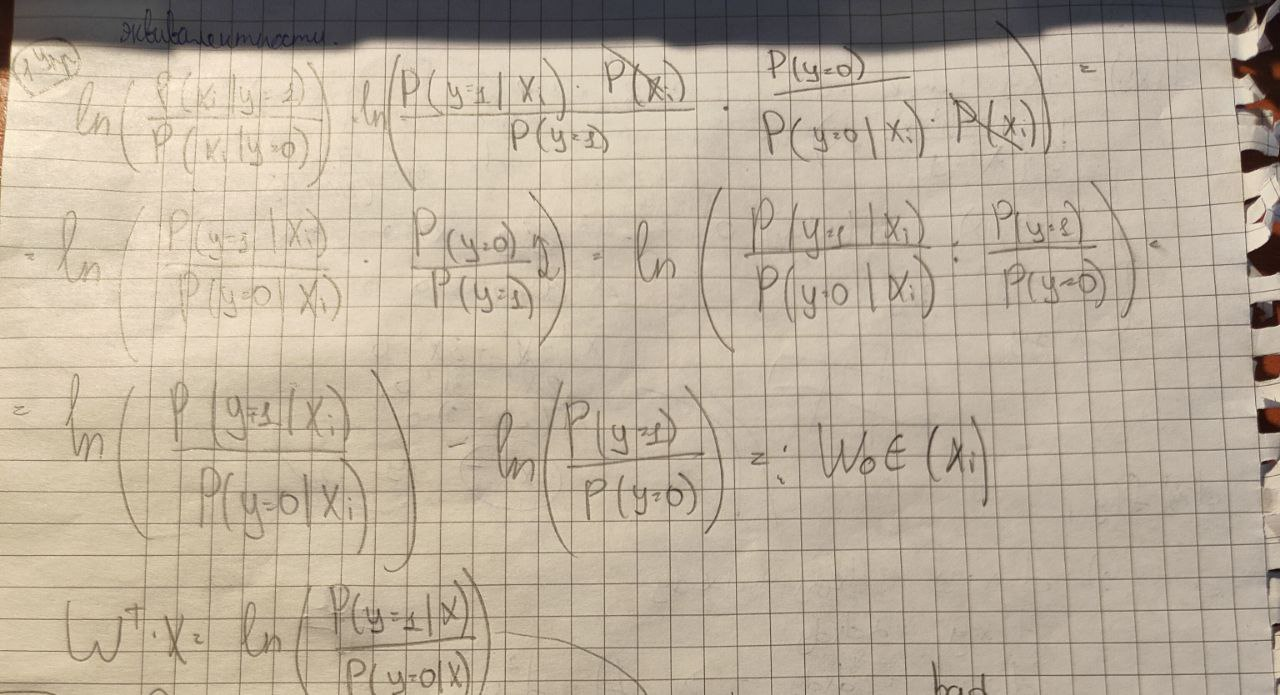

#### **Упражнение 2**

Известно:

$WoE$ можно посчитать так:
$WoE_i(x_i) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) $

Частота выхода в дефолт:  $badrate = \frac{B}{B+G}; \quad badrate_i = \frac{B_i}{B_i+G_i}$

$
\sigma (x) = \frac{1}{1+e^{-x}}; \quad logit(x) = \ln \left( \frac{x}{1-x} \right)
$

**Покажите, что**
$WoE_i(x_i) = logit(badrate_i) - logit(badrate)$

photo_2024-03-20_19-24-28.jpg

#### **Упражнение 3**

Пусть даны два дискретных распределения:

$B=(b_1, ..., b_n)$ и $G=(g_1, ..., g_n)$.

KL-дивергенция для дискретных распределений

$$D_{KL}(B||G) = \sum_{j=1}^{n} b_j \ln \left( \frac{b_j}{g_j} \right)$$


Пусть $x$ - дикретный признак, принмиающий значения $x_1,...,x_n$.
Известно определение IV через KL-дивергенцию:

$$
IV_x = D_{KL}(B_x||G_x)+D_{KL}(G_x||B_x)
$$
где

$$
B_x (x_i) = P(x=x_i|y=1) = b_i; \quad G_x (x_i) = P(x=x_i|y=0) = g_i
$$

**Выразите $IV$ через $WoE$**





Если что я приложил фотки через колаб, поэтому они может быть не открываются
